# An Improved Reliability-Based Approach to Sepcifying Fire Resistance Periods For Buildings in England

Analysis documentation for the research topic submitted for ASFE 2021.

_2021 April, Ian F._

In the design of fire safety provisions for straightforward/common buildings in England the appropriate structural fire resistance is selected from guidance based upon building height and occupancy characteristics. This has been expanded upon in contemporary guidance to include consideration of ventilation conditions informed by work carried out in 2004 by Kirby, et al. in their paper “A new approach to specifying fire resistance periods” and has been implemented in British Standard, BS 9999:2017. In the work of Kirby, et al., a probabilistic time equivalence analysis was carried out using Monte Carlo simulations (MCS). Stochastic parameters were used to produce a range of credible design fires. These were primarily fuel load density, compartment geometry and ventilation opening size. The design fires were generated using the parametric fire model in EN 1991-1-2 and the contribution of sprinklers was considered through a reduced fire load. To link to existing fire resistance recommendations which did not consider ventilation, the safety/reliability target was calibrated to align with statutory guidance, Approved Document B (ADB), using a medium-rise office as an anchor point.

This study revisits the work of Kirby et al., resolving key limitations and incorporating advancements in the field to present a new approach to assessing the recommended fire resistance for structures and proposes a revised fire resistance design table for England. To seek alignment with general structural design principles/requirements, as defined in Approved Document A (ADA), safety targets are expressed in function of consequence classes in lieu of building height and use. Other key advancements include improved stochastic parameters, the use of travelling fires where post-flashover parametric fires are unrealistic (i.e., a more explicit consideration of large enclosure fire dynamics), and consideration of sprinkler contribution in the event tree in terms of their ability to mitigate structurally significant fire occurrences.

The improved approach presented provides a more up to date method for defining appropriate fire resistance for straightforward/common buildings in England.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path
from sys import platform
from scipy.interpolate import interp1d
from typing import Callable

from sfeprapy.mcs2 import MCS2
from sfeprapy.mcs.mcs_gen_2 import InputParser

plt.style.use('seaborn-white')

# User defined, project folder containing inputs
if platform == "darwin":
    fp_project = r'/Volumes/ssd01/projects_fse/ASFE2021/01-analysis'
    path.exists(fp_project)
elif platform == "win32":
    fp_project = r'D:\projects_fse\!ASFE2021\01-analysis'
    path.exists(fp_project)

# Helper function
def get_teq_fractile_func(teq: np.ndarray) -> Callable:
    print()
    hist, edges = np.histogram(teq, bins=np.arange(0, max(361, max(teq[teq<np.inf])+0.5), 0.5))
    x, y = (edges[:-1] + edges[1:]) / 2, np.cumsum(hist / np.sum(hist))
    func_teq = interp1d(x, y, bounds_error=False)
    return func_teq

# Helper function
def get_teq_fractile(teq: np.ndarray, fr: list = list(range(30, 181, 15))) -> np.ndarray:
    return get_teq_fractile_func(teq = teq)(fr)

# Helper function
def get_teq_fractile_dict(teq_dict: dict, fr: list = list(range(30, 181, 15)), is_print: bool = True) -> dict:
    """Prints CFD of given time equivalence values"""
    res_dict = dict(Time=fr)
    for case, teq in teq_dict.items():
        res_dict[case] = get_teq_fractile(teq=teq, fr=fr)
    if is_print is True:
        print(pd.DataFrame.from_dict(res_dict))
    return res_dict

## Benchmark against Kirby et al

### Run time equivalence Monte Carlo simulations

The analysis is comprised of three cases: Office, Resiential and Retail. All input parameters are inline with Kirby et al.

#### Inputs

In [2]:
fn = '0-trial_00.xlsx'

if platform == 'win32':
    fp_inputs = path.realpath(path.join(r'D:\projects_fse\!ASFE2021\01-analysis', fn[2:10], fn))
elif platform == 'darwin':
    fp_inputs = path.realpath(path.join(r'/Volumes/ssd01/projects_fse/ASFE2021/01-analysis', fn[2:10], fn))

df_inputs = pd.read_excel(fp_inputs, index_col='case_name')
df_inputs.loc[[
    'fire_load_density:dist', 'fire_load_density:mean', 'fire_load_density:sd', 
    'fire_hrr_density:dist', 'fire_hrr_density:lbound', 'fire_hrr_density:ubound', 
    'room_height:dist', 'room_height:lbound', 'room_height:ubound', 
    'room_floor_area:dist', 'room_floor_area:lbound', 'room_floor_area:ubound', 
    'room_breadth_depth_ratio:dist', 'room_breadth_depth_ratio:lbound', 'room_breadth_depth_ratio:ubound', 
    'window_height_room_height_ratio:dist', 'window_height_room_height_ratio:lbound', 'window_height_room_height_ratio:ubound', 
    'window_area_floor_ratio:dist', 'window_area_floor_ratio:lbound', 'window_area_floor_ratio:ubound'
]]

,Residential,Office,Retail
case_name,,,
fire_load_density:dist,gumbel_r_,gumbel_r_,gumbel_r_
fire_load_density:mean,780,420,600
fire_load_density:sd,234,126,180
fire_hrr_density:dist,uniform_,uniform_,uniform_
fire_hrr_density:lbound,0.32,0.15,0.27
fire_hrr_density:ubound,0.57,0.65,1
room_height:dist,constant_,uniform_,uniform_
room_height:lbound,2.4,2.8,4.5
room_height:ubound,2.4,4.5,7


#### Simulation

In [3]:
# Run MCS
cases_to_run=['Office', 'Residential', 'Retail']

mcs2 = MCS2(print_stats=False)
mcs2.inputs = fp_inputs
mcs2.n_threads = 6
mcs2.run_mcs(cases_to_run=cases_to_run)

CASE                    : Residential
NO. OF THREADS          : 6
NO. OF SIMULATIONS      : 10000


100%|███████████████| 10000/10000 [00:04<00:00, 2480.50it/s]


CASE                    : Office
NO. OF THREADS          : 6
NO. OF SIMULATIONS      : 10000


100%|███████████████| 10000/10000 [00:03<00:00, 3281.86it/s]


CASE                    : Retail
NO. OF THREADS          : 6
NO. OF SIMULATIONS      : 10000


100%|███████████████| 10000/10000 [00:03<00:00, 3312.84it/s]


#### Results

Inspect simulation results to ensure the simulations are complete successfully.

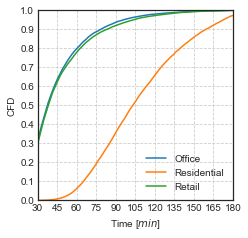

In [15]:
# Inspect simulation results
mcs_out = mcs2.mcs_out
dict_teq = {case: mcs_out.loc[mcs_out['case_name'] == case]["solver_time_equivalence_solved"] / 60.0 for case in cases_to_run}
dict_teq_fractile = get_teq_fractile_dict(dict_teq, is_print=False, fr=np.linspace(0, 180, 100))

fig, ax = plt.subplots(figsize=(3.5,3.5))
for case in cases_to_run:
    ax.plot(dict_teq_fractile['Time'], dict_teq_fractile[case], label=case)
ax.legend().set_visible(True)
ax.set_xlabel('Time [$min$]')
ax.set_ylabel('CFD')
ax.set_xlim(30, 180)
ax.set_ylim(0, 1)
ax.set_xticks(np.arange(30, 181, 15,))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.grid(True, ls='--');

It is obvious Residential produced much worse time equivalence results comparing to the other two, primarily due to higher fuel load density.

#### Comparing agsint Kirby et al

| FR  | Office | Retail  | Residential |
|-----|--------|---------|-------------|
| 30  | 0.464  | 0.40416 | 0.16901     |
| 45  | 0.6474 | -       | 0.19285     |
| 60  | 0.8    | 0.73384 | 0.36078     |
| 75  | 0.8963 | -       | 0.62947     |
| 90  | 0.928  | 0.91238 | 0.84399     |
| 105 | 0.9727 | -       | 0.95341     |
| 120 | 0.982  | 0.96824 | 0.99133     |

In [16]:
data = {
    'Office': {
        'Equivalent of time exposure': [30, 60, 90, 120, 150],
        'CDF (Kirby et al)': [0.464, 0.8, 0.928, 0.982, 0.996],
        'CDF (SFEPRAPY)': get_teq_fractile(
            teq=mcs_out.loc[mcs_out['case_name'] == 'Office']["solver_time_equivalence_solved"] / 60.0,
            fr=[30, 60, 90, 120, 150]
        )
    },
    'Retail': {
        'Equivalent of time exposure': [30, 60, 90, 120],
        'CDF (Kirby et al)': [0.4041621029572837, 0.7338444687842278, 0.9123767798466594, 0.968236582694414],
        'CDF (SFEPRAPY)': get_teq_fractile(
            teq=mcs_out.loc[mcs_out['case_name'] == 'Retail']["solver_time_equivalence_solved"] / 60.0,
            fr=[30, 60, 90, 120]
        )
    },
    'Dwelling': {
        'Equivalent of time exposure': [60, 75, 90, 105, 120],
        'CDF (Kirby et al)': [0.36078, 0.62947, 0.84399, 0.95341, 0.99133,],
        'CDF (SFEPRAPY)': get_teq_fractile(
            teq=mcs_out.loc[mcs_out['case_name'] == 'Residential']["solver_time_equivalence_solved"] / 60.0,
            fr=[60, 75, 90, 105, 120]
        )
    }
}

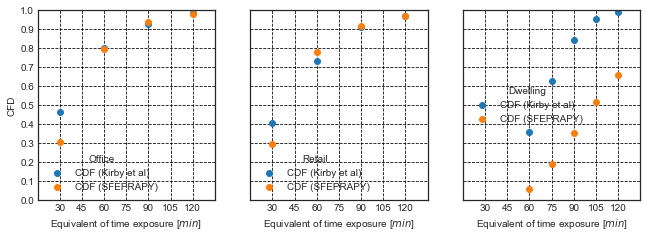

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3.6*3, 3.5), sharex=True, sharey=True)

for i, k in enumerate(data.keys()):
    ax, v = axes[i], data[k]
    ax.scatter(v['Equivalent of time exposure'], v['CDF (Kirby et al)'], label='CDF (Kirby et al)')
    ax.scatter(v['Equivalent of time exposure'], v['CDF (SFEPRAPY)'], label='CDF (SFEPRAPY)')
    ax.legend(title=k).set_visible(True)
    ax.set_xlabel('Equivalent of time exposure [$min$]')
    ax.set_xlim(15, 135)
    ax.set_xticks(np.arange(30, 121, 15))
    ax.grid(which='both', ls='--', c='k')

ax = axes[0]
ax.set_ylabel('CFD')
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0,1.1,0.1));

## Convert Kirby et al to Failure Probability

In [18]:
failure_parameters = {
    "Residential": dict(p1=6.5e-7, p2=0.2, p3=0.25, p4=1),
    "Office": dict(p1=3.0e-7, p2=0.2, p3=0.25, p4=1),
    "Retail": dict(p1=4.0e-7, p2=0.2, p3=0.25, p4=1),
}

